<a href="https://colab.research.google.com/github/amandalinsg/MVP-ML/blob/main/MVP_ML_Amanda_Lins.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

DRAFT 1 - MVP MACHINE LEARNING PUC RIO

#1. Definicao do Problema

## 1.1 Problema de Classificação
O modelo de ML que criarei terá os seguintes objetivos:
1. Prever a categoria do produto com base no texto.
2. Identificar o sentimento das avaliaçoes.
3. Identificar o tema/categoria principal das avaliacoes (ex.: "preço", "qualidade", "embalagem").


Serao dois modelos interdependentes: um para a parte do sentimento e outro para a categorizacao de tema/categoria. Sendo assim, usarei técnicas de multi-saída.


#2. EXPLORACAO E PREPARACAO DOS DADOS

In [14]:
!pip install fuzzywuzzy
import pandas as pd

# Carregar o arquivo .xlsx
file_url = 'https://github.com/amandalinsg/MVP-ML/raw/main/AMZ-review-details.xlsx'
df = pd.read_excel(file_url)

# Visualizar as primeiras linhas
print(df.head())


  report_date online_store            upc retailer_product_code  \
0  2019-01-02  FRESHAMAZON  8718114216478            B0142CI6FC   
1  2019-01-03  FRESHAMAZON  5000184201199            B014DFNNRY   
2  2019-01-03  FRESHAMAZON  5000184201199            B014DFNNRY   
3  2019-01-03  FRESHAMAZON  8712566479726            B014DFKELC   
4  2019-01-03  FRESHAMAZON  8717163536476            B014G37I7E   

           brand       category sub_category  \
0  Dove Men+Care  Personal Care         Deos   
1        Marmite          Foods      Savoury   
2        Marmite          Foods      Savoury   
3          Knorr          Foods      Savoury   
4            Cif       Homecare          HHC   

                                 product_description review_date  \
0  Dove Men+Care Extra Fresh Anti-perspirant Deod...  2019-01-01   
1                 Marmite  Spread Yeast Extract 500g  2019-01-02   
2                 Marmite  Spread Yeast Extract 500g  2019-01-02   
3                      Knorr  Beef S

In [15]:
# Verificar as colunas
print(df.columns)

# Checar valores ausentes
print(df.isnull().sum())

Index(['report_date', 'online_store', 'upc', 'retailer_product_code', 'brand',
       'category', 'sub_category', 'product_description', 'review_date',
       'review_rating', 'review_title', 'review_text', 'is_competitor',
       'manufacturer', 'market', 'matched_keywords', 'time_of_publication',
       'url', 'review_type', 'parent_review', 'manufacturers_response',
       'dimension1', 'dimension2', 'dimension3', 'dimension4', 'dimension5',
       'dimension6', 'dimension7', 'dimension8', 'verified_purchase',
       'helpful_review_count', 'review_hash_id'],
      dtype='object')
report_date                  0
online_store                 0
upc                          0
retailer_product_code        0
brand                        0
category                     0
sub_category                 0
product_description          0
review_date                  0
review_rating                0
review_title               105
review_text                  0
is_competitor                0
manufa

## 2.2 Limpeza de Colunas e Atributos

In [16]:
# Remover colunas com muitos nulos (com limite de 70%)
threshold = 0.7
cols_to_drop = df.columns[df.isnull().mean() > threshold]
df = df.drop(columns=cols_to_drop)
print(f"Colunas removidas: {cols_to_drop}")

Colunas removidas: Index(['matched_keywords', 'time_of_publication', 'manufacturers_response',
       'dimension4', 'dimension5', 'dimension6'],
      dtype='object')


In [17]:
# Deixar apenas as células que contem texto e ratings válidos
df = df.dropna(subset=['review_text', 'review_rating'])



##2.3 Conversao dos ratings em categorias de sentimento

In [18]:
# Criar colunas de sentimento
def map_rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating == 3:
        return 'neutral'
    else:
        return 'negative'

df['Sentiment'] = df['review_rating'].apply(map_rating_to_sentiment)
print(df['Sentiment'].value_counts())

Sentiment
positive    2167
negative     227
neutral      107
Name: count, dtype: int64


## 2.4 VETORIZACAO DE TEXTO

O objetivo da vetorizacao é preparar os dados textuais, neste caso dos reviews, para serem usados em um modelo de ML para fazer análise de sentimentos ou tópicos/palavras mais relevantes. O texto é transformado em TF-IDF (Term Frequency-Inverse Document Frequency), formato numérico que pode ser processado pelo modelo.

Para vetorizar o texto dos campos da coluna "review_text",
utilizei o **TfidfVectorizer** que faz parte da biblioteca scikit-learn.

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer



Através do TfidfVectorizer, um objeto é criado com 2 parâmetros:

1. **max_features=5000**: Limita o número máximo de palavras consideradas para vetorização para um máximo de 5000 palavras mais frequentes/relevantes, com o objetivo de simplificar o processamento.
2. **stop_words='english'**: Remove palavras comuns do ingles (ex.: "and", "the", "is"), que geralmente não agregam valor para a análise de sentimentos.




In [20]:
# Criar matriz TF-IDF
vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
X = vectorizer.fit_transform(df['review_text'])
y = df['Sentiment']  # Rótulos



1.   Entrada (df['Review Text']): Representa a coluna dos textos das avaliações.
2. **fit_transform**: Transforma o texto em uma matriz esparsa, onde: as linhas representam as avaliações e as colunas representam palavras selecionadas.

3.   Os valores serao os pesos TF-IDF dados a cada palavra das avaliacoes.
4.   O resultado (X) será uma matriz esparsa que vai ser usada como entrada no modelo de aprendizado.
5. Y=Sentiment é a variável de saída (rótulos). Cada valor representa a classe de sentimento de cada avaliação ( "positivo", "negativo" ou "neutro").



## 2.5 SEPARACAO TREINO E TESTE

 ### 2.5.1 DIVISAO ESTRATIFICADA

Para garantir que as proporcoes das classes do conjunto de treinamento e teste sejam as mesmas que das originais, eu apliquei a divisao estratificada, novamente com a biblioteca sklearn.

Escolhi separar treino e teste na proporcao 20/80. E dividi dados duas vezes, uma para rótulos de categorias e outra de sentimentos.

Detalhe:



*   X: Matriz de características (vetorizada).
*   y_category: Rótulos para categorias.
*   y_sentiment: Rótulos para sentimento.

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,  # Dados vetorizados
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

###2.5.2 BALANCEAMENTO DAS CLASSES

Tendo em conta que existe um desequilíbrio entre quantidade de positivos e neutros/negativos, busquei aplicar uma técnica de balanceamento OVERSAMPLING "SMOTE", que aumenta a quantidade de amostras das classes minoritárias replicando exemplos existentes ou criando novos dados.

In [22]:
from imblearn.over_sampling import SMOTE

# Aplicar oversampling nas classes minoritárias
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_train, y_train)

# Verificar nova distribuição
from collections import Counter
print("Distribuição após oversampling:", Counter(y_balanced))


Distribuição após oversampling: Counter({'negative': 1733, 'positive': 1733, 'neutral': 1733})


#3. MODELAGEM E TREINAMENTO

##3.1 RANDOM FOREST - TREINAMENTO MULTITAREFA (CLASSICO)

Escolhi o modelo **RANDOM FOREST** por ser um modelo robusto, fácil de usar e capaz de lidar bem com problemas de classificação, como análise de textos. O treinamento será **MULTITAREFA**, já que quero que o modelo preveja duas classes: SENTIMENTOS e ASPECTOS.
Utilizei a biblioteca sklearn uma vez mais.

Detalhe:
1. Sentimentos (positive, negative, neutral).
2. Aspectos (price, quality,scent, packaging, etc).

###3.1.1 Modelo Random Forest para Sentimentos

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

# Modelo para sentimentos
rf_sentiment = RandomForestClassifier(random_state=42, n_estimators=200)
rf_sentiment.fit(X_balanced, y_balanced)

# Avaliação
y_pred_sentiment = rf_sentiment.predict(X_test)
print("Relatório de Sentimentos:\n", classification_report(y_test, y_pred_sentiment))


Relatório de Sentimentos:
               precision    recall  f1-score   support

    negative       0.96      0.57      0.71        46
     neutral       0.80      0.38      0.52        21
    positive       0.93      1.00      0.96       434

    accuracy                           0.93       501
   macro avg       0.90      0.65      0.73       501
weighted avg       0.93      0.93      0.92       501



###3.1.2 Modelo Random Forest para Aspectos

1. Primeiro definirei os aspectos com as keywords adequadas, incluindo sinonimos:

In [50]:
aspect_keywords = {
    "price": ["price", "cost", "value", "expensive", "cheap", "affordable"],
    "quality": ["quality", "durability", "material", "reliable", "sturdy"],
    "packaging": ["packaging", "box", "container", "wrap", "bottle"],
    "scent": ["scent", "smell", "fragrance", "aroma"],
    "gentleness": ["gentleness", "soft", "delicate", "harsh"],
    "flavour": ["flavour", "taste", "savory", "bitter", "sweet"],
    "effectiveness": ["effectiveness", "performance", "works", "efficacy"],
    "others": ["design", "appearance", "color", "instructions", "size"]
}


2. Em seguida, utilizarei a biblioteca fuzzywuzzy com a finalidade de capturar palavras com ***typos***(erros ou pequenas diferencas na escrita), e também capturar múltiplos "aspectos" em cada review:

In [52]:
from fuzzywuzzy import fuzz

In [63]:
def classify_multiple_aspects_with_fuzzy_phrases(text, threshold=80):
    text = text.lower()
    detected_aspects = []  # Lista para armazenar os aspectos detectados

    for aspect, keywords in aspect_keywords.items():
        for keyword in keywords:
            similarity = fuzz.partial_ratio(keyword, text)  # Usar partial_ratio para frases (e nao somente palavras soltas)
            print(f"Comparando '{keyword}' com texto: Similaridade = {similarity}")
            if similarity >= threshold:
                detected_aspects.append(aspect)
                break  # Evitar adicionar o mesmo aspecto várias vezes

    return detected_aspects if detected_aspects else ["other"]  # Retorna 'other' se nenhum aspecto for detectado


# Teste com frase com typo e 3 aspectos distintos:
text_example = "The prise is affordable, but the material is not sturdy and the scent is amazing."
detected_aspects = classify_multiple_aspects_with_fuzzy_phrases(text_example)
print("Aspectos detectados:", detected_aspects)


Comparando 'price' com texto: Similaridade = 80
Comparando 'quality' com texto: Similaridade = 43
Comparando 'durability' com texto: Similaridade = 50
Comparando 'material' com texto: Similaridade = 100
Comparando 'packaging' com texto: Similaridade = 56
Comparando 'box' com texto: Similaridade = 33
Comparando 'container' com texto: Similaridade = 44
Comparando 'wrap' com texto: Similaridade = 25
Comparando 'bottle' com texto: Similaridade = 50
Comparando 'scent' com texto: Similaridade = 100
Comparando 'gentleness' com texto: Similaridade = 40
Comparando 'soft' com texto: Similaridade = 25
Comparando 'delicate' com texto: Similaridade = 50
Comparando 'harsh' com texto: Similaridade = 40
Comparando 'flavour' com texto: Similaridade = 43
Comparando 'taste' com texto: Similaridade = 60
Comparando 'savory' com texto: Similaridade = 50
Comparando 'bitter' com texto: Similaridade = 50
Comparando 'sweet' com texto: Similaridade = 40
Comparando 'effectiveness' com texto: Similaridade = 38
Com

In [65]:
# Aplicar a função de classificação a cada review
df['aspects_detected'] = df['review_text'].apply(classify_multiple_aspects_with_fuzzy_phrases)

# Visualizar o DataFrame resultante
print(df[['review_text', 'aspects_detected']].head())


Se han truncado las últimas 5000 líneas del flujo de salida.
Comparando 'bitter' com texto: Similaridade = 33
Comparando 'sweet' com texto: Similaridade = 20
Comparando 'effectiveness' com texto: Similaridade = 31
Comparando 'performance' com texto: Similaridade = 18
Comparando 'works' com texto: Similaridade = 20
Comparando 'efficacy' com texto: Similaridade = 12
Comparando 'price' com texto: Similaridade = 40
Comparando 'cost' com texto: Similaridade = 50
Comparando 'value' com texto: Similaridade = 40
Comparando 'expensive' com texto: Similaridade = 67
Comparando 'cheap' com texto: Similaridade = 40
Comparando 'affordable' com texto: Similaridade = 40
Comparando 'quality' com texto: Similaridade = 43
Comparando 'durability' com texto: Similaridade = 40
Comparando 'material' com texto: Similaridade = 50
Comparando 'reliable' com texto: Similaridade = 50
Comparando 'sturdy' com texto: Similaridade = 33
Comparando 'packaging' com texto: Similaridade = 33
Comparando 'box' com texto: Sim

3. Criarei a visualizacao da Distribuicao dos Aspectos, para observar se há alguma categoria em desequilíbrio:

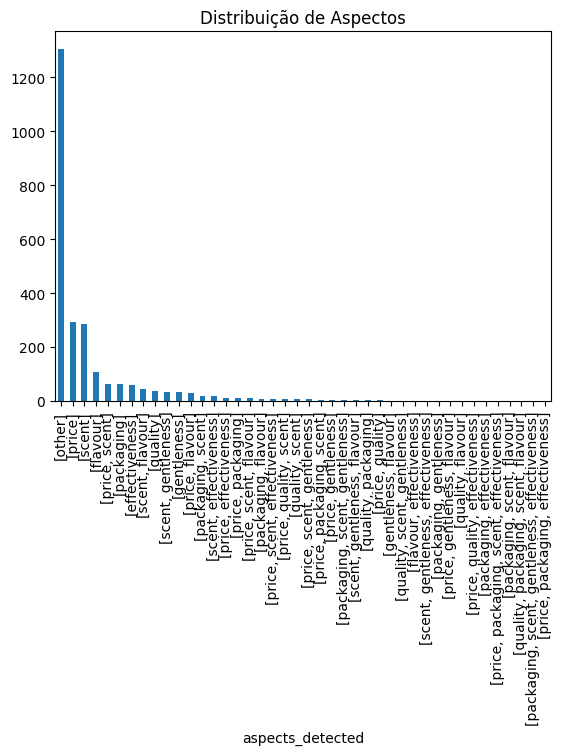

In [82]:
import matplotlib.pyplot as plt

df['aspects_detected'].value_counts().plot(kind='bar', title='Distribuição de Aspectos')
plt.show()


Acima pude verificar que a categoria "other" está *over-represented*, o que provavelmente significa que os keywords nao estao tao bem classificados. Entao, a seguir, irei:

1. Aplicar TF-IDF para Identificar Palavras Relevantes do aspecto "OTHER":

In [80]:
# Filtrar apenas linhas onde 'aspects_detected' contém 'other'
df_other = df[df['aspects_detected'].apply(lambda x: "other" in x)]

# Aplicar o TF-IDF às avaliações filtradas
vectorizer = TfidfVectorizer(max_features=20, stop_words='english')
tfidf_matrix = vectorizer.fit_transform(df_other['review_text_cleaned'])

# Obter as palavras mais frequentes em "other"
print("Palavras mais frequentes em 'other':", vectorizer.get_feature_names_out())


Palavras mais frequentes em 'other': ['buy' 'clean' 'collected' 'dry' 'face' 'good' 'great' 'like' 'love'
 'product' 'promotion' 'really' 'review' 'skin' 'smell' 'soft' 'use'
 'used' 'using' 'wipes']


Conhecendo as palavras mais frequentes que anteriormente foram classificadas como "other", vou incrementar a lista de keywords, agregando novas categorias, baseadas nessas palavras frequentes:

In [89]:
aspect_keywords1 = {
    "price": ["price", "cost", "value", "expensive", "cheap", "affordable"],
    "quality": ["quality", "durability", "material", "reliable", "sturdy"],
    "packaging": ["packaging", "box", "container", "wrap", "bottle"],
    "scent": ["scent", "smell", "fragrance", "aroma"],
    "gentleness": ["gentleness", "soft", "delicate", "harsh"],
    "flavour": ["flavour", "taste", "savory", "bitter", "sweet"],
    "effectiveness": ["effectiveness", "performance", "works", "efficacy"],
    "others": ["design", "appearance", "color", "instructions", "size"],
    "cleanliness": ["clean"],
    "promotion":["discount", "promotion"],


}

In [94]:
def classify_multiple_aspects_with_fuzzy_phrases(text, threshold=80):
    text = text.lower()
    detected_aspects = []  # Lista para armazenar os aspectos detectados

    for aspect, keywords in aspect_keywords1.items():
        for keyword in keywords:
            similarity = fuzz.partial_ratio(keyword, text)  # Usar partial_ratio para frases (e nao somente palavras soltas)
            print(f"Comparando '{keyword}' com texto: Similaridade = {similarity}")
            if similarity >= threshold:
                detected_aspects.append(aspect)
                break  # Evitar adicionar o mesmo aspecto várias vezes

    return detected_aspects if detected_aspects else ["other"]  # Retorna 'other' se nenhum aspecto for detectado


# Teste com frase com typo e 3 aspectos distintos:
text_example = "The prise is affordable and it cleans well, but the material is not sturdy and the scent is amazing."
detected_aspects = classify_multiple_aspects_with_fuzzy_phrases(text_example)
print("Aspectos detectados:", detected_aspects)

Comparando 'price' com texto: Similaridade = 80
Comparando 'quality' com texto: Similaridade = 43
Comparando 'durability' com texto: Similaridade = 40
Comparando 'material' com texto: Similaridade = 100
Comparando 'packaging' com texto: Similaridade = 56
Comparando 'box' com texto: Similaridade = 33
Comparando 'container' com texto: Similaridade = 44
Comparando 'wrap' com texto: Similaridade = 50
Comparando 'bottle' com texto: Similaridade = 50
Comparando 'scent' com texto: Similaridade = 100
Comparando 'gentleness' com texto: Similaridade = 40
Comparando 'soft' com texto: Similaridade = 25
Comparando 'delicate' com texto: Similaridade = 50
Comparando 'harsh' com texto: Similaridade = 40
Comparando 'flavour' com texto: Similaridade = 43
Comparando 'taste' com texto: Similaridade = 60
Comparando 'savory' com texto: Similaridade = 50
Comparando 'bitter' com texto: Similaridade = 50
Comparando 'sweet' com texto: Similaridade = 40
Comparando 'effectiveness' com texto: Similaridade = 38
Com

In [97]:
# Aplicar a função de classificação a cada review
df['aspects_detected1'] = df['review_text'].apply(classify_multiple_aspects_with_fuzzy_phrases)

Se han truncado las últimas 5000 líneas del flujo de salida.
Comparando 'reliable' com texto: Similaridade = 38
Comparando 'sturdy' com texto: Similaridade = 33
Comparando 'packaging' com texto: Similaridade = 22
Comparando 'box' com texto: Similaridade = 67
Comparando 'container' com texto: Similaridade = 33
Comparando 'wrap' com texto: Similaridade = 50
Comparando 'bottle' com texto: Similaridade = 50
Comparando 'scent' com texto: Similaridade = 40
Comparando 'smell' com texto: Similaridade = 60
Comparando 'fragrance' com texto: Similaridade = 33
Comparando 'aroma' com texto: Similaridade = 40
Comparando 'gentleness' com texto: Similaridade = 40
Comparando 'soft' com texto: Similaridade = 75
Comparando 'delicate' com texto: Similaridade = 25
Comparando 'harsh' com texto: Similaridade = 40
Comparando 'flavour' com texto: Similaridade = 43
Comparando 'taste' com texto: Similaridade = 40
Comparando 'savory' com texto: Similaridade = 33
Comparando 'bitter' com texto: Similaridade = 33
Co

Agora, quero contar as ocorrencias de cada aspecto de forma separada:

1. Primeiro, vou "explodir" os aspectos de 'aspects_detected1', utilizando o método explode() do pandas para transformar cada lista de aspectos em uma linha separada:

In [101]:
# Explodir os aspectos detectados em linhas separadas
df_exploded = df.explode('aspects_detected1')




2. Logo vou contar os valores dos aspects_detected1 com o método value_counts(), para contar os aspectos individualmente:

In [102]:
aspect_counts = df_exploded['aspects_detected1'].value_counts()
print(aspect_counts)


aspects_detected1
other            1214
scent             518
price             460
flavour           211
cleanliness       147
packaging         119
effectiveness     107
gentleness         94
others             81
quality            60
promotion           6
Name: count, dtype: int64


3. Finalmente, irei criar a visualizacao dos aspectos contados acima:

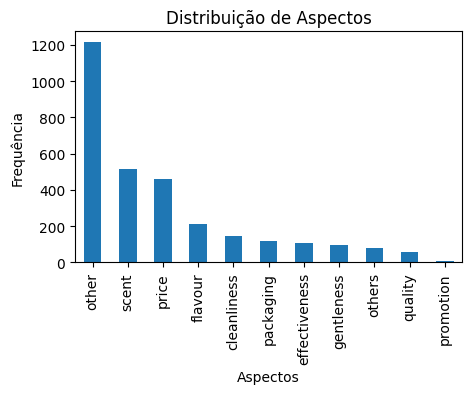

In [104]:
import matplotlib.pyplot as plt

# Criar o gráfico de barras
aspect_counts.plot(kind='bar', title='Distribuição de Aspectos', figsize=(5, 3))
plt.xlabel('Aspectos')
plt.ylabel('Frequência')
plt.show()


Pude verificar que as categorias agora estao melhor classificadas, de forma mais balanceadas que antes.

In [105]:
# Criar colunas binárias para cada aspecto
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
aspect_labels = mlb.fit_transform(df['aspects_detected1'])

# Verificar as colunas criadas
aspect_columns = mlb.classes_
df_aspects = pd.DataFrame(aspect_labels, columns=aspect_columns)
print(df_aspects.head())

# Combinar com o texto original
df_combined = pd.concat([df, df_aspects], axis=1)


   cleanliness  effectiveness  flavour  gentleness  other  others  packaging  \
0            0              0        0           0      0       0          0   
1            0              0        0           0      1       0          0   
2            0              0        0           0      1       0          0   
3            0              0        1           0      0       0          0   
4            0              0        0           0      1       0          0   

   price  promotion  quality  scent  
0      0          0        0      1  
1      0          0        0      0  
2      0          0        0      0  
3      0          0        0      0  
4      0          0        0      0  


In [107]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Dividir os dados
X_train, X_test, y_train, y_test = train_test_split(X, df_aspects, test_size=0.2, random_state=42)

# Modelo Multilabel
multi_rf = OneVsRestClassifier(RandomForestClassifier(random_state=42, n_estimators=200))
multi_rf.fit(X_train, y_train)

# Avaliar o modelo
y_pred = multi_rf.predict(X_test)

# Relatório para cada classe
print("Relatório de Classificação Multilabel:\n")
for idx, column in enumerate(aspect_columns):
    print(f"Aspecto: {column}")
    print(classification_report(y_test, y_pred, zero_division=0))


Relatório de Classificação Multilabel:

Aspecto: cleanliness
              precision    recall  f1-score   support

           0       1.00      0.68      0.81        31
           1       1.00      0.52      0.68        25
           2       1.00      0.71      0.83        42
           3       1.00      0.58      0.73        19
           4       0.89      0.95      0.92       247
           5       1.00      0.62      0.77        16
           6       1.00      0.60      0.75        20
           7       1.00      0.92      0.96        95
           8       0.00      0.00      0.00         1
           9       1.00      0.56      0.71         9
          10       0.94      0.84      0.89        96

   micro avg       0.94      0.84      0.89       601
   macro avg       0.89      0.63      0.73       601
weighted avg       0.95      0.84      0.88       601
 samples avg       0.89      0.86      0.87       601

Aspecto: effectiveness
              precision    recall  f1-score   sup

#4. Conclusao sobre performance dos modelos

##4.1 Modelo Random Forest para Sentimentos

1. Desempenho Geral: O modelo apresentou boa acurácia geral (93%), mas priorizou a classe com mais ocorrencias ("positive").
2. Classe "Positive": Excelente desempenho com alta precisão (0.93) e recall perfeito (1.00).
3. Classe "Negative": Boa precisão (0.96), mas recall baixo (0.57), indicando dificuldade em identificar todas as avaliações negativas.
4. Classe "Neutral": Desempenho fraco (F1-Score: 0.52) devido ao baixo recall (0.38) e suporte reduzido.

Problemas Identificados:

* Desequilíbrio de classes, com predominância de "positive".
* Baixo desempenho para "negative" e "neutral" devido à ambiguidade e menor quantidade de exemplos.


##3.1 ESCOLHA DO MODELO

Escolhi utilizar um modelo pré treinado chamado Zero-Shot Classification, baseado no BERT (Bidirecional Encoder Representations from Transformers), que faz modelagem de liguagem e previsao da proxima frase. A vantagem do Zero-Shot é que possibilita a identificacao de sinonimos e permite que os "typos" nao sejam ignorados pelo modelo.

Abaixo realizei um teste com o código BERT, onde determinei os "aspects" que neste caso sao as categorias/características de produto que poderiam sair nos reviews. *Obs.: Testei um typo (qualitee) e um sinonimo de scent (smell) para confirmar que sairía no "result = classifier". E sim, funcionou:*

In [2]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")
candidate_aspects = ["price", "scent", "quality", "packaging"]
text = "The qualitee and smell are amazing, but the cost is too high."
result = classifier(text, candidate_aspects)
print(result)



{'sequence': 'The qualitee and smell are amazing, but the cost is too high.', 'labels': ['quality', 'price', 'scent', 'packaging'], 'scores': [0.5650864839553833, 0.24345429241657257, 0.18893857300281525, 0.002520641777664423]}


In [ ]:
from transformers import pipeline

# Inicializar o pipeline
zero_shot_classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

# Categorias de aspectos
aspect_categories = ["price", "quality", "packaging"]

# Categorias de sentimentos
sentiment_categories = ["positive", "negative", "neutral"]

# Função para aplicar o Zero-Shot
def classify_zero_shot(text, categories):
    result = zero_shot_classifier(text, candidate_labels=categories)
    return result['labels'][0], result['scores'][0]

# Aplicar Zero-Shot para identificar aspectos no conjunto de treino
X_train_aspect, X_train_aspect_score = zip(*X_train.apply(lambda x: classify_zero_shot(x, aspect_categories)))
X_test_aspect, X_test_aspect_score = zip(*X_test.apply(lambda x: classify_zero_shot(x, aspect_categories)))

# Aplicar Zero-Shot para identificar sentimentos no conjunto de treino
X_train_sentiment, X_train_sentiment_score = zip(*X_train.apply(lambda x: classify_zero_shot(x, sentiment_categories)))
X_test_sentiment, X_test_sentiment_score = zip(*X_test.apply(lambda x: classify_zero_shot(x, sentiment_categories)))

# Adicionar os resultados ao dataframe
df_train = pd.DataFrame({
    "review_text": X_train,
    "aspect": X_train_aspect,
    "aspect_score": X_train_aspect_score,
    "sentiment": X_train_sentiment,
    "sentiment_score": X_train_sentiment_score
})

df_test = pd.DataFrame({
    "review_text": X_test,
    "aspect": X_test_aspect,
    "aspect_score": X_test_aspect_score,
    "sentiment": X_test_sentiment,
    "sentiment_score": X_test_sentiment_score
})

# Visualizar
print(df_train.head())
print(df_test.head())
